# Final Model Evaluation

Final evaluation of the selected model on holdout test dataset for business decision making.


In [26]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# Add scripts directory to Python path
sys.path.insert(0, os.path.abspath('../../scripts/'))

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries loaded successfully")


Libraries loaded successfully


## Load Final Model and Test Data


In [27]:
# Load final model
with open('../../models/final/final_model.pkl', 'rb') as f:
    final_model = pickle.load(f)

# Load model selection summary
with open('../../models/final/model_selection_summary.pkl', 'rb') as f:
    selection_summary = pickle.load(f)

# Load test data
test_data = pd.read_csv('../../data/split/test.csv')

print(f"Final model loaded: {type(final_model).__name__}")
print(f"Test data shape: {test_data.shape}")
print(f"Selected model: {selection_summary.get('selected_model', 'N/A')}")
print(f"Selection date: {selection_summary.get('selection_date', 'N/A')}")


Final model loaded: TransformedTargetRegressor
Test data shape: (292, 81)
Selected model: Ridge Regression Basic (Tuned)
Selection date: 2025-09-03 16:42:11


In [28]:
# Prepare test data
X_test = test_data.drop('SalePrice', axis=1)
y_test = test_data['SalePrice']

print(f"Features: {X_test.shape[1]}")
print(f"Test samples: {len(y_test)}")
print(f"Price range: ${y_test.min():,.0f} - ${y_test.max():,.0f}")


Features: 80
Test samples: 292
Price range: $35,311 - $625,000


## Generate Predictions


In [29]:
# Make predictions
y_pred = final_model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final Model Performance on Holdout Test Set:")
print(f"RMSE: ${rmse:,.0f}")
print(f"MAE:  ${mae:,.0f}")
print(f"R²:   {r2:.4f}")

# Calculate prediction accuracy by price range
def accuracy_by_range(y_true, y_pred, ranges):
    results = {}
    for label, (low, high) in ranges.items():
        mask = (y_true >= low) & (y_true < high)
        if mask.sum() > 0:
            subset_rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
            subset_r2 = r2_score(y_true[mask], y_pred[mask])
            results[label] = {'count': mask.sum(), 'rmse': subset_rmse, 'r2': subset_r2}
    return results

price_ranges = {
    'Low (< $150k)': (0, 150000),
    'Mid ($150k-$300k)': (150000, 300000),
    'High (> $300k)': (300000, float('inf'))
}

range_results = accuracy_by_range(y_test, y_pred, price_ranges)
print("\nPerformance by Price Range:")
for range_name, metrics in range_results.items():
    print(f"{range_name}: {metrics['count']} houses, RMSE=${metrics['rmse']:,.0f}, R²={metrics['r2']:.3f}")


Final Model Performance on Holdout Test Set:
RMSE: $21,708
MAE:  $13,630
R²:   0.9265

Performance by Price Range:
Low (< $150k): 124 houses, RMSE=$12,858, R²=0.721
Mid ($150k-$300k): 147 houses, RMSE=$20,685, R²=0.726
High (> $300k): 21 houses, RMSE=$50,807, R²=0.676


## Performance Visualizations


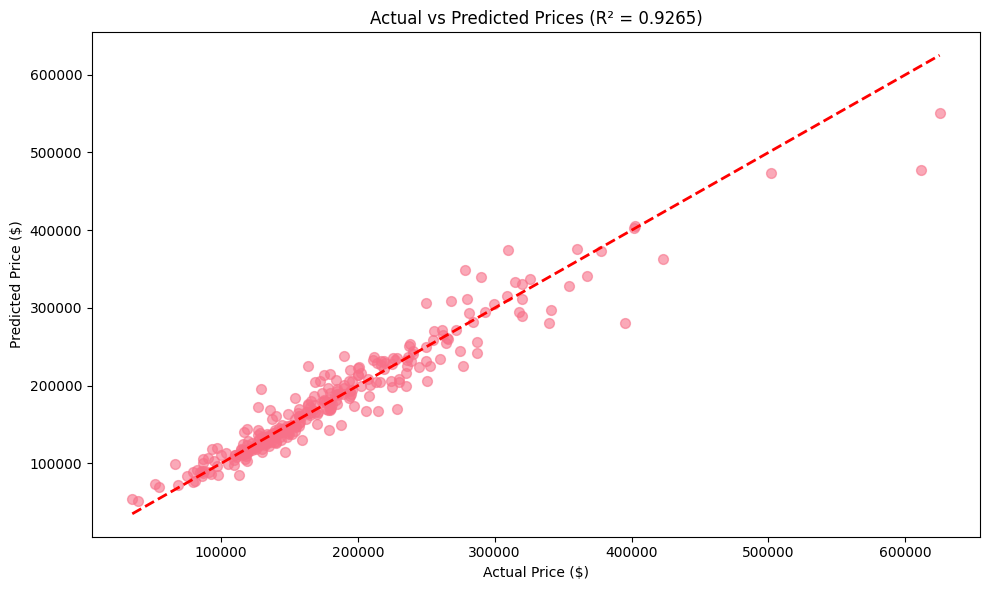

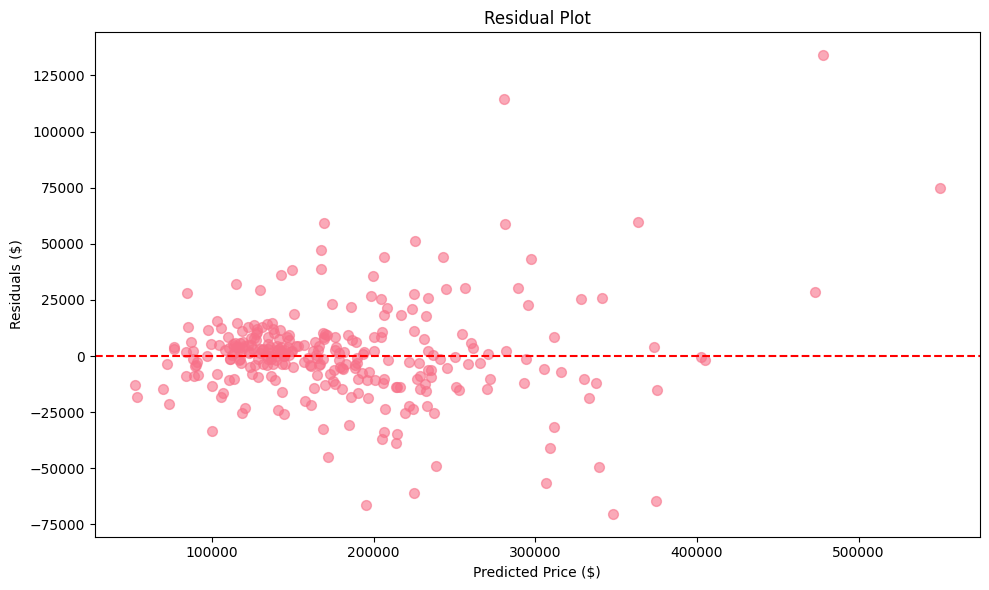

In [30]:
# Create results directory
import os
os.makedirs('../../results/images', exist_ok=True)

# 1. Actual vs Predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Actual vs Predicted Prices (R² = {r2:.4f})')
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.savefig('../../results/images/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, s=50)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.savefig('../../results/images/residual_plot.png', dpi=300, bbox_inches='tight')
plt.show()


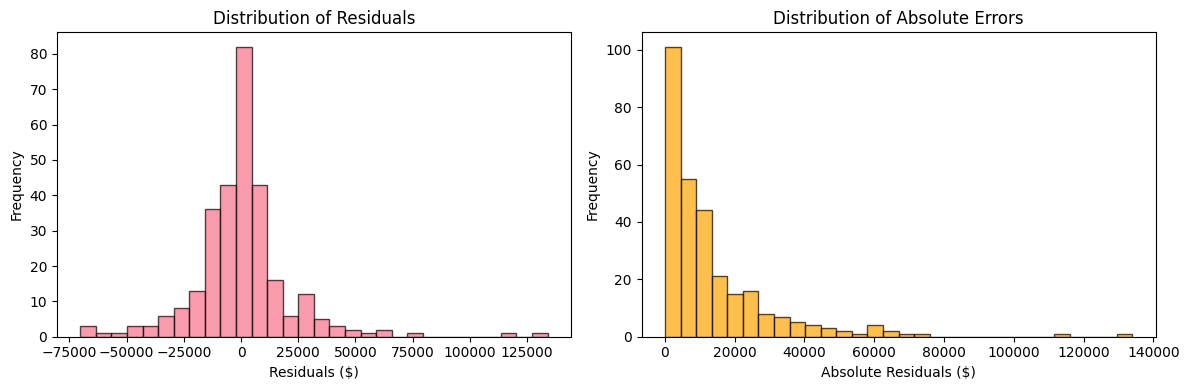

Mean absolute error: $13,630
Median absolute error: $8,312
90th percentile error: $32,538


In [31]:
# 3. Error distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.ticklabel_format(style='plain', axis='x')

plt.subplot(1, 2, 2)
plt.hist(np.abs(residuals), bins=30, alpha=0.7, edgecolor='black', color='orange')
plt.xlabel('Absolute Residuals ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Errors')
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.savefig('../../results/images/error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Mean absolute error: ${np.mean(np.abs(residuals)):,.0f}")
print(f"Median absolute error: ${np.median(np.abs(residuals)):,.0f}")
print(f"90th percentile error: ${np.percentile(np.abs(residuals), 90):,.0f}")


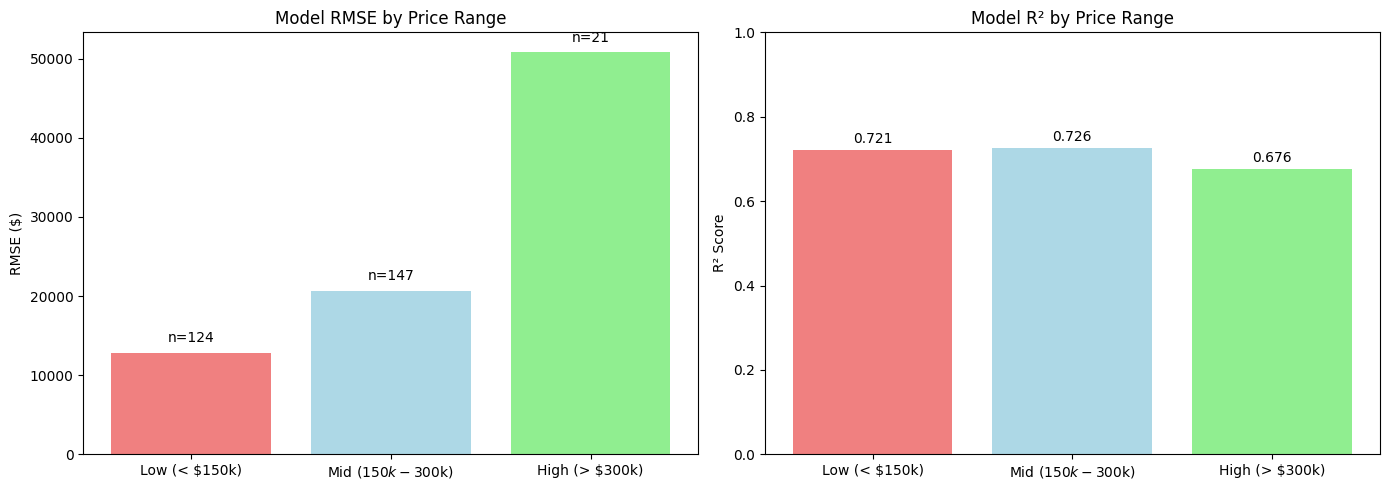

In [32]:
# 4. Performance by price range visualization
range_names = list(range_results.keys())
rmse_values = [range_results[name]['rmse'] for name in range_names]
r2_values = [range_results[name]['r2'] for name in range_names]
counts = [range_results[name]['count'] for name in range_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# RMSE by price range
bars1 = ax1.bar(range_names, rmse_values, color=['lightcoral', 'lightblue', 'lightgreen'])
ax1.set_ylabel('RMSE ($)')
ax1.set_title('Model RMSE by Price Range')
ax1.ticklabel_format(style='plain', axis='y')
for i, (bar, count) in enumerate(zip(bars1, counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'n={count}', ha='center', va='bottom', fontsize=10)

# R² by price range
bars2 = ax2.bar(range_names, r2_values, color=['lightcoral', 'lightblue', 'lightgreen'])
ax2.set_ylabel('R² Score')
ax2.set_title('Model R² by Price Range')
ax2.set_ylim(0, 1)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../../results/images/performance_by_range.png', dpi=300, bbox_inches='tight')
plt.show()


In [34]:
# Calculate additional metrics for business analysis
prediction_errors = np.abs(residuals)
confidence_90 = np.percentile(prediction_errors, 90)
confidence_95 = np.percentile(prediction_errors, 95)
high_error_threshold = mae * 2
high_error_count = np.sum(np.abs(residuals) > high_error_threshold)
high_error_rate = high_error_count / len(residuals) * 100
avg_house_price = y_test.mean()
error_as_pct_of_price = (mae / avg_house_price) * 100

# Save evaluation results for reports
evaluation_results = {
    'model_type': type(final_model).__name__,
    'test_samples': len(y_test),
    'metrics': {
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    },
    'confidence_intervals': {
        '90_percent': float(confidence_90),
        '95_percent': float(confidence_95)
    },
    'performance_by_range': range_results,
    'business_metrics': {
        'avg_house_price': float(avg_house_price),
        'error_percentage': float(error_as_pct_of_price),
        'high_error_rate': float(high_error_rate),
        'high_error_threshold': float(high_error_threshold)
    }
}

# Save results
os.makedirs('../../models/final', exist_ok=True)
with open('../../models/final/evaluation_results.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)

print("✓ Evaluation results saved for business analysis")

✓ Evaluation results saved for business analysis
